# 04-09

## Challenge 01 - Electricity Consumption Exploration

---

![](https://images.unsplash.com/photo-1487875961445-47a00398c267?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1650&q=80)
Photo by [Jason Blackeye](https://unsplash.com/photos/nyL-rzwP-Mk)

In this exercise, you will be asked to explore time series data in several ways.

You will be working with time series of Open Power System Data ([OPSD](https://open-power-system-data.org/)) for Germany. 

The data set includes daily electricity consumption, wind power production, and solar power production between 2006 and 2017. 
```
- Date — The date (yyyy-mm-dd format)
- Consumption — Electricity consumption in GWh
- Wind — Wind power production in GWh
- Solar — Solar power production in GWh
- Wind+Solar — Sum of wind and solar power production in GWh
```

# Data Exploration

In [14]:
# Imports
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime as dt

import matplotlib.pyplot as plt

import seaborn as sns

import plotly.express as px

In [15]:
# Load file
df = pd.read_csv('opsd_germany_daily.csv')

In [16]:
# Description
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         4383 non-null   object 
 1   Consumption  4383 non-null   float64
 2   Wind         2920 non-null   float64
 3   Solar        2188 non-null   float64
 4   Wind+Solar   2187 non-null   float64
dtypes: float64(4), object(1)
memory usage: 171.3+ KB


In [17]:
df.describe()

Consumption         Wind        Solar   Wind+Solar
count  4383.000000  2920.000000  2188.000000  2187.000000
mean   1338.675836   164.814173    89.258695   272.663481
std     165.775710   143.692732    58.550099   146.319884
min     842.395000     5.757000     1.968000    21.478000
25%    1217.859000    62.353250    35.179250   172.185500
50%    1367.123000   119.098000    86.407000   240.991000
75%    1457.761000   217.900250   135.071500   338.988000
max    1709.568000   826.278000   241.580000   851.556000

Then, make sure to transform the dates into datetime format in pandas :

In [18]:
df.Date

0       2006-01-01
1       2006-01-02
2       2006-01-03
3       2006-01-04
4       2006-01-05
           ...    
4378    2017-12-27
4379    2017-12-28
4380    2017-12-29
4381    2017-12-30
4382    2017-12-31
Name: Date, Length: 4383, dtype: object

In [19]:
# Transform the dates into datetime format
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')

In [20]:
df.set_index('Date', drop=True, inplace=True)

In [21]:
df

Consumption     Wind   Solar  Wind+Solar
Date                                                
2006-01-01   1069.18400      NaN     NaN         NaN
2006-01-02   1380.52100      NaN     NaN         NaN
2006-01-03   1442.53300      NaN     NaN         NaN
2006-01-04   1457.21700      NaN     NaN         NaN
2006-01-05   1477.13100      NaN     NaN         NaN
...                 ...      ...     ...         ...
2017-12-27   1263.94091  394.507  16.530     411.037
2017-12-28   1299.86398  506.424  14.162     520.586
2017-12-29   1295.08753  584.277  29.854     614.131
2017-12-30   1215.44897  721.247   7.467     728.714
2017-12-31   1107.11488  721.176  19.980     741.156

[4383 rows x 4 columns]

### 1. Plotting and understanding a time series

Q1 - Plot the different time series. What do you understand, what do you notice ?

In [22]:
px.line(data_frame=df,x=df.index, y='Consumption', title="Consumption over time")

In [23]:
px.line(data_frame=df,x=df.index, y='Wind', title="Wind over time")

In [24]:
px.line(data_frame=df,x=df.index, y='Solar', title="Solar over time")

In [25]:
px.line(data_frame=df,x=df.index, y='Wind+Solar', title="Wind+Solar over time")

We can also avoid plotting lines and simply plot dots for the consumption :

In [26]:
px.scatter(data_frame=df,x=df.index, y='Consumption', title="Consumption over time")

We notice that consumption is lower during weekends. This cannot be seen using the line plot.

And plot the production over time :

In [27]:
px.scatter(data_frame=df,x=df.index, y='Wind+Solar', title="Wind+Solar over time")

We see on this curve that the solar power seasonality is reflected on the global production curve, so the production is a bit seasonal (more solar power during summers, more wind power during winters).

What can we notice ?

How do consumption and production compare ?

In [28]:
df['Prod-Cons'] = df['Wind+Solar']-df['Consumption']

In [29]:
px.scatter(data_frame=df,x=df.index, y='Prod-Cons', title="Production minus consumption over time")

We can see that production is not sufficient compared to the consumption. Moreover, production particularly lacking during winters where consumption is higher (needs for heating) but the lack of solar power is not compensated by the increase of wind.

### 2. Change the scale

Q2 - Try to change the scale to understand the recurrent patterns !

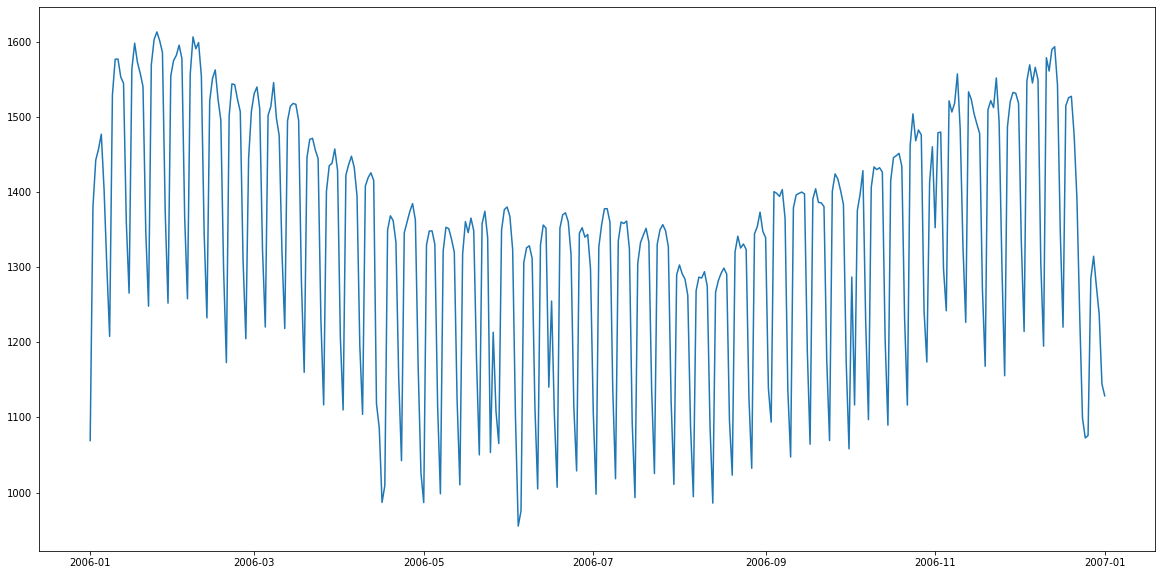

In [30]:
# Plot over the year
plt.figure(figsize=(20,10))
plt.plot(df['Consumption'][:366])
plt.show()

It confirms the trend : more consumption in winter time, and less in summer. We can then zoom on a given month :

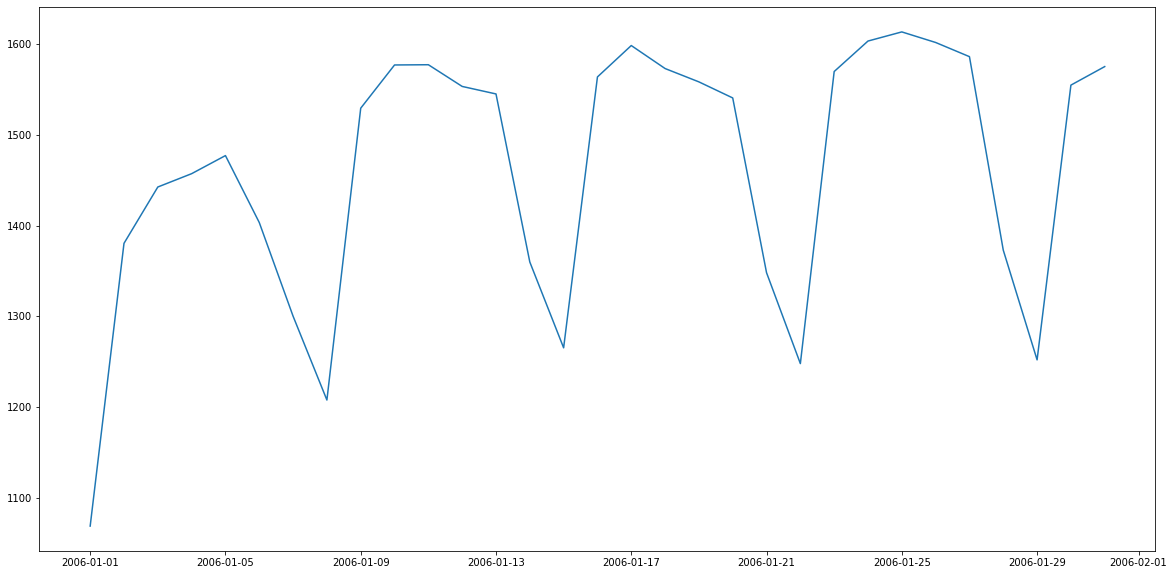

In [31]:
# Plot over a month
plt.figure(figsize=(20,10))
plt.plot(df['Consumption'][:31])
plt.show()

When zooming on a month, we oberve another seasonality. There seems to be days of the week in which people consume less. For example, here's what happens when we highlight Sundays :

In [32]:
def isSunday(dates):
    return [date.weekday()==6 for date in dates]

In [33]:
df['isSunday'] = isSunday(df.index)

In [34]:
df

Consumption     Wind   Solar  Wind+Solar  Prod-Cons  isSunday
Date                                                                     
2006-01-01   1069.18400      NaN     NaN         NaN        NaN      True
2006-01-02   1380.52100      NaN     NaN         NaN        NaN     False
2006-01-03   1442.53300      NaN     NaN         NaN        NaN     False
2006-01-04   1457.21700      NaN     NaN         NaN        NaN     False
2006-01-05   1477.13100      NaN     NaN         NaN        NaN     False
...                 ...      ...     ...         ...        ...       ...
2017-12-27   1263.94091  394.507  16.530     411.037 -852.90391     False
2017-12-28   1299.86398  506.424  14.162     520.586 -779.27798     False
2017-12-29   1295.08753  584.277  29.854     614.131 -680.95653     False
2017-12-30   1215.44897  721.247   7.467     728.714 -486.73497     False
2017-12-31   1107.11488  721.176  19.980     741.156 -365.95888      True

[4383 rows x 6 columns]

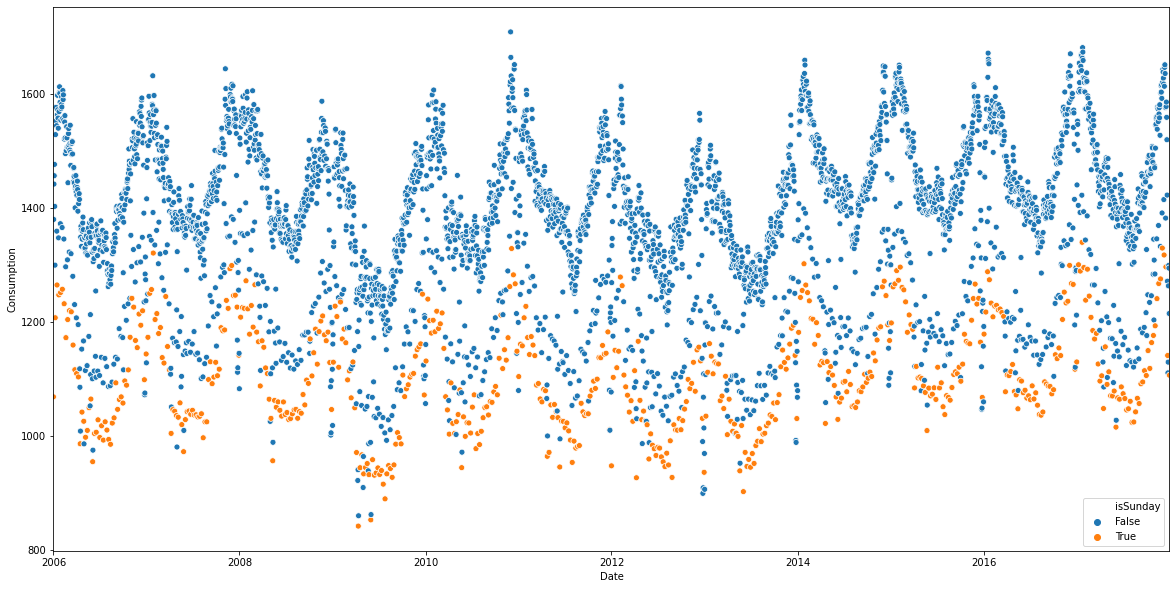

In [35]:
# Plot on Sundays
plt.figure(figsize=(20,10))
sns.scatterplot(x=df.index, y=df.Consumption, hue=df.isSunday)
plt.xlim((df.index[0], df.index[-1]))
plt.legend(loc='lower right')
plt.show()

### 3. Further exploration

Q3 - To further explore the dataset, we might need to group the data. Create new columns for the consumption (by year and month), and create box-plots with seaborn. Comment on your results.

In [36]:
# new columns 'year' and 'month'

In [37]:
df.index.year

Int64Index([2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006,
            ...
            2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017],
           dtype='int64', name='Date', length=4383)

In [38]:
df['Year'] = df.index.year

In [39]:
df['Month'] = df.index.month

In [40]:
df

Consumption     Wind   Solar  Wind+Solar  Prod-Cons  isSunday  \
Date                                                                        
2006-01-01   1069.18400      NaN     NaN         NaN        NaN      True   
2006-01-02   1380.52100      NaN     NaN         NaN        NaN     False   
2006-01-03   1442.53300      NaN     NaN         NaN        NaN     False   
2006-01-04   1457.21700      NaN     NaN         NaN        NaN     False   
2006-01-05   1477.13100      NaN     NaN         NaN        NaN     False   
...                 ...      ...     ...         ...        ...       ...   
2017-12-27   1263.94091  394.507  16.530     411.037 -852.90391     False   
2017-12-28   1299.86398  506.424  14.162     520.586 -779.27798     False   
2017-12-29   1295.08753  584.277  29.854     614.131 -680.95653     False   
2017-12-30   1215.44897  721.247   7.467     728.714 -486.73497     False   
2017-12-31   1107.11488  721.176  19.980     741.156 -365.95888      True   

            Year  Month  
Date                     
2006-01-01  2006      1  
2006-01-02  2006      1  
2006-01-03  2006      1  
2006-01-04  2006      1  
2006-01-05  2006      1  
...          ...    ...  
2017-12-27  2017     12  
2017-12-28  2017     12  
2017-12-29  2017     12  
2017-12-30  2017     12  
2017-12-31  2017     12  

[4383 rows x 8 columns]

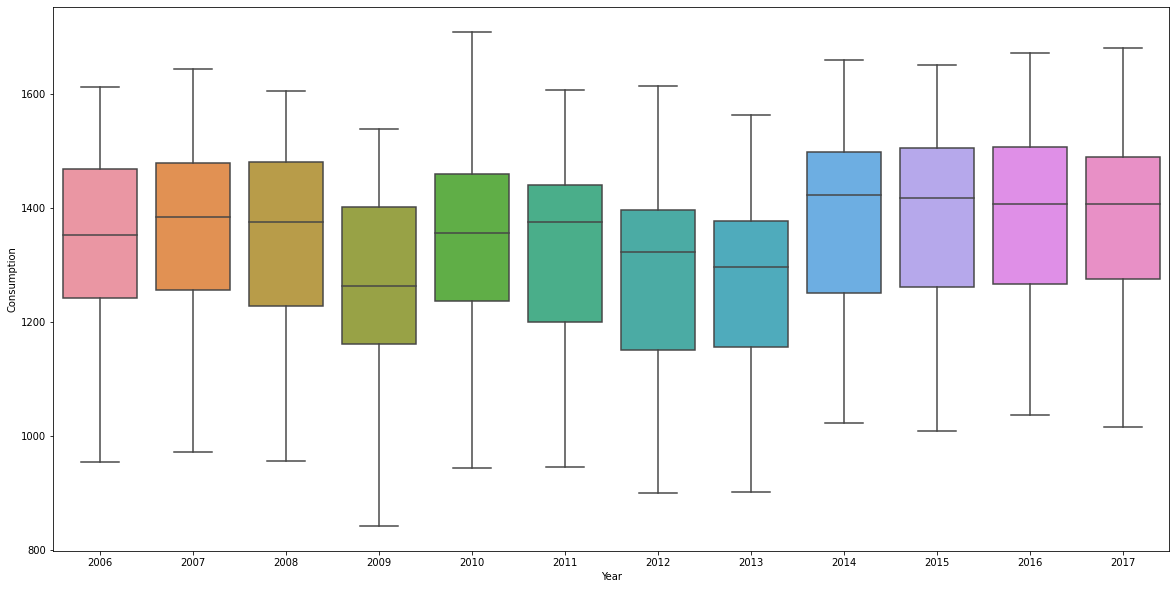

In [44]:
# Boxplot year
plt.figure(figsize=(20,10))
sns.boxplot(x='Year', y='Consumption', data=df)
plt.show()

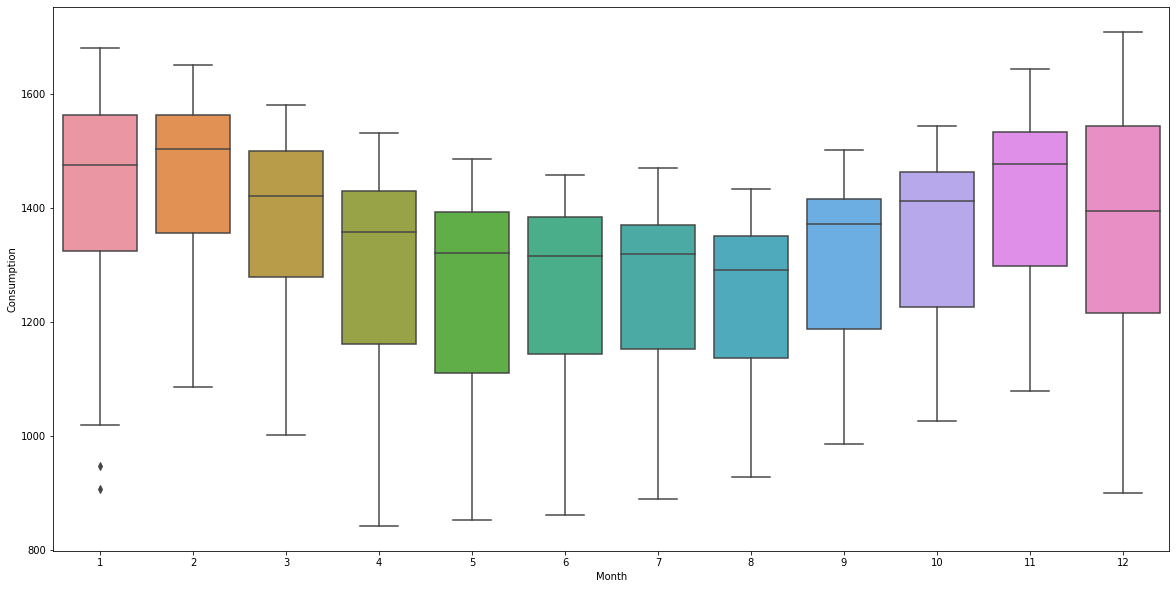

In [45]:
# Boxplot month
plt.figure(figsize=(20,10))
sns.boxplot(x='Month', y='Consumption', data=df)
plt.show()

### 4. Fill missing values

Q4 - Do you face missing values in production ? If yes, which method can you apply ? What happens if you plot the modified data ? It is a good idea to keep the data this way ?

There are missing values on wind production before 2010 and on solar production before 2012.

For solar production, we could just repeat the pattern we observe on previous years. For wind production, it is more complicated as there is no obvious pattern in wind.

In [373]:
interpo = df['Solar'].interpolate(method='quadratic', limit_direction='backward')

In [374]:
interpo[:365*6+2]

Date
2006-01-01      NaN
2006-01-02      NaN
2006-01-03      NaN
2006-01-04      NaN
2006-01-05      NaN
              ...  
2011-12-28      NaN
2011-12-29      NaN
2011-12-30      NaN
2011-12-31      NaN
2012-01-01    6.587
Name: Solar, Length: 2192, dtype: float64

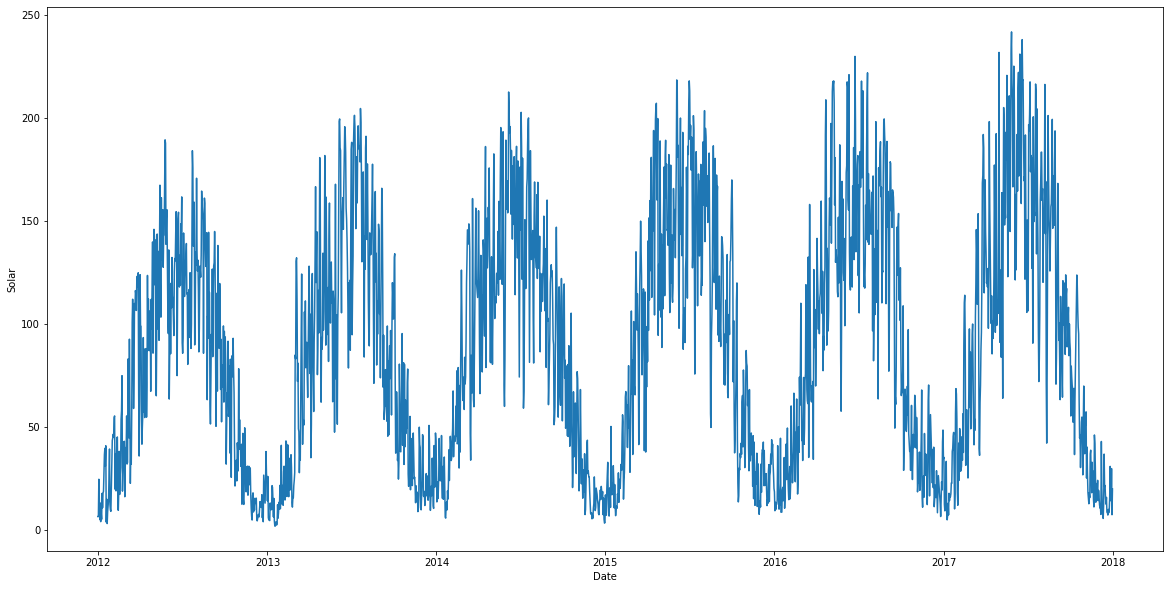

In [361]:
plt.figure(figsize=(20,10))
sns.lineplot(x=df.index, y=df.Solar)
sns.lineplot(x=df.index[:365*6], y=interpo[:365*6])
plt.show()

### 5. Series correlation

Q5 - A good way to explore time series, when you have several series, is to plot one series vs another. This is a good way to estimate the correlation between 2 series. Plot the relevant graphs (and compute the correlation) for wind + solar vs consumption, wind vs consumption, solar vs consumption and wind vs solar.

In [296]:
# Correlation between consumption and overall production
corr1 = df.corr().loc['Consumption', 'Wind+Solar']

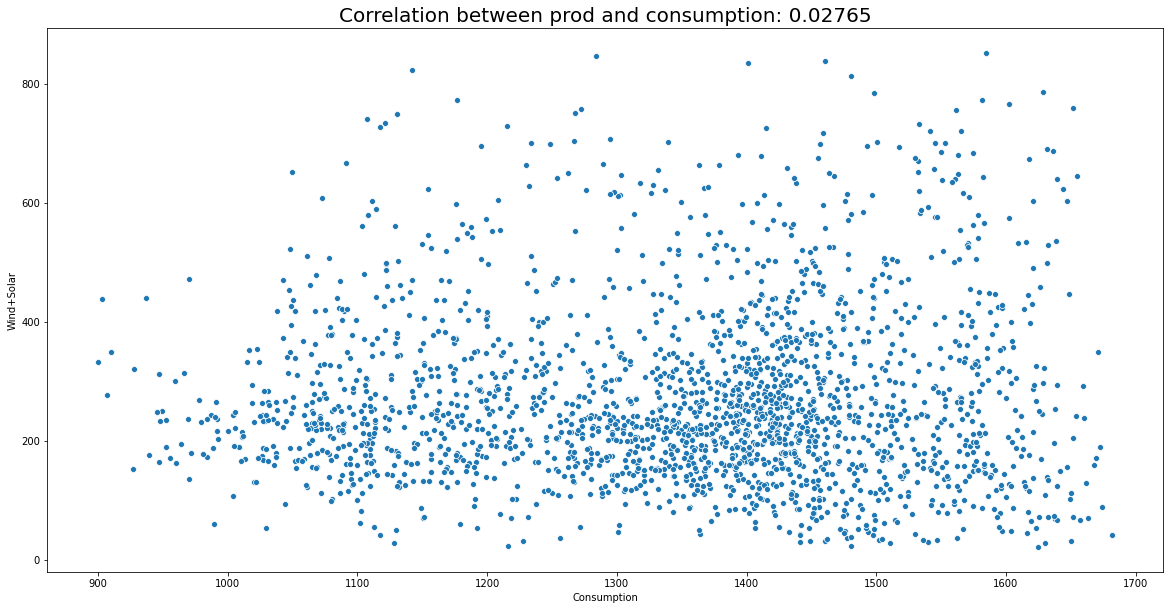

In [297]:
# Plot
plt.figure(figsize=(20,10))
sns.scatterplot(x='Consumption', y='Wind+Solar', data=df)
plt.title(f'Correlation between prod and consumption: {corr1:.4}', fontdict={'fontsize':20})
plt.show()

In [298]:
# Correlation between solar production and wind production
corr2 = df.corr().loc['Solar', 'Wind']

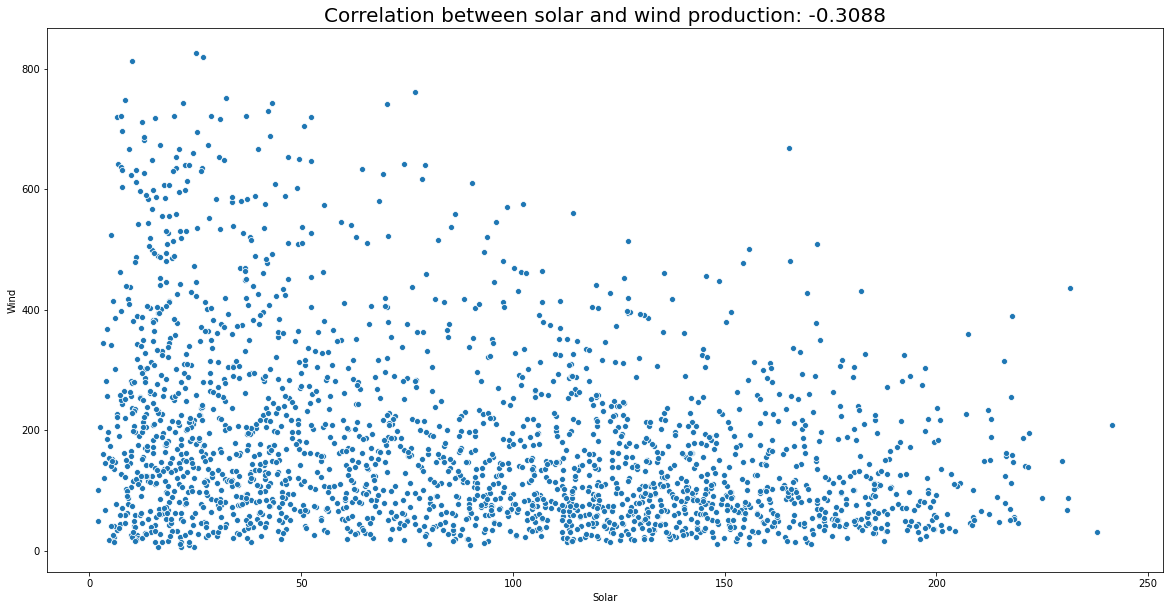

In [299]:
# Plot
plt.figure(figsize=(20,10))
sns.scatterplot(x='Solar', y='Wind', data=df)
plt.title(f'Correlation between solar and wind production: {corr2:.4}', fontdict={'fontsize':20})
plt.show()

In [301]:
# Correlation between consumption and wind production
corr3 = df.corr().loc['Consumption', 'Wind']

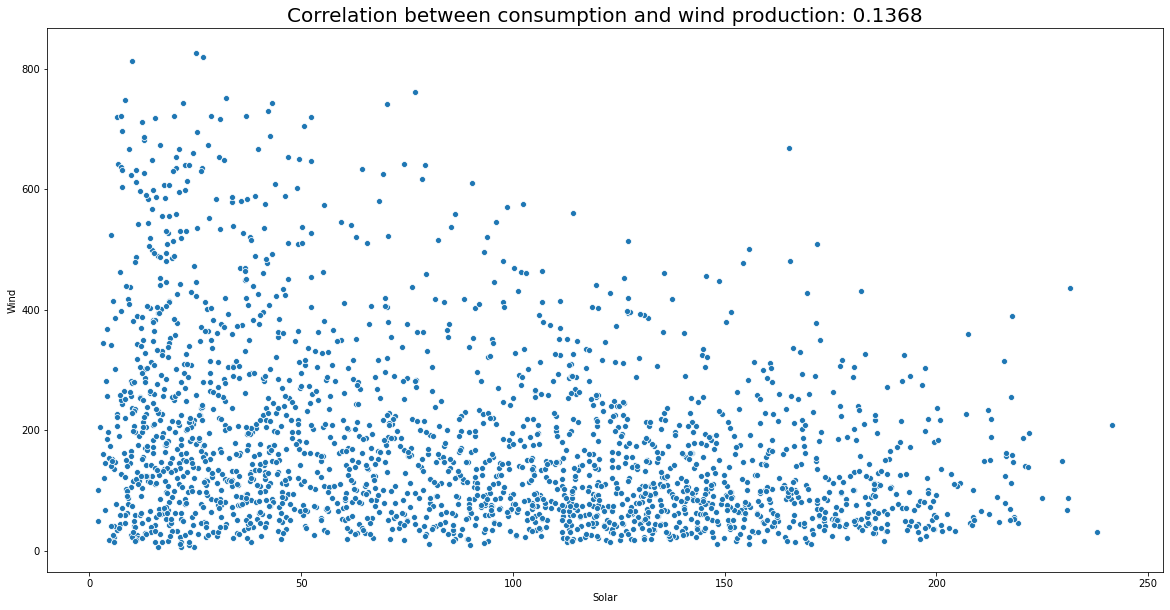

In [302]:
# Plot
plt.figure(figsize=(20,10))
sns.scatterplot(x='Solar', y='Wind', data=df)
plt.title(f'Correlation between consumption and wind production: {corr3:.4}', fontdict={'fontsize':20})
plt.show()

In [303]:
# Correlation between consumption and solar production
corr4 = df.corr().loc['Consumption', 'Solar']

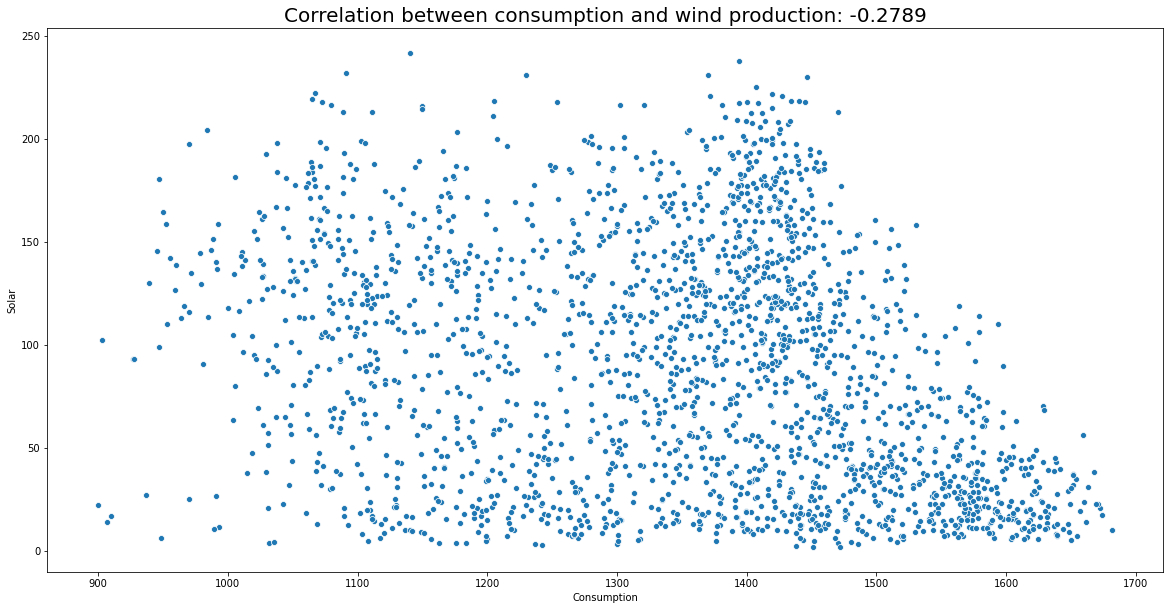

In [305]:
# Plot
plt.figure(figsize=(20,10))
sns.scatterplot(x='Consumption', y='Solar', data=df)
plt.title(f'Correlation between consumption and wind production: {corr4:.4}', fontdict={'fontsize':20})
plt.show()